# Unsupervised vs. Supervised Machine Translation

In this tutorial, we'll use Adaptor to look at the **difference in accuracy** when training domain-specific translator using standard **Supervised** vs. **Unsupervised objectives**. We'll also use one extra domain to estimate the distributional **robustness** of our translator throughout the adaptation.

* For the supervised adaptation and evaluations, we'll use standard *Sequence2Sequence* (i.e. MLE) objective.
* For the unsupervised adaptation, we'll use Adaptor's unsupervised *BackTranslation* objectice.

#### Requirements

In [1]:
# %%capture

!git clone https://github.com/gaussalgo/adaptor.git
!pip install -e adaptor

In [2]:
# add the utils directory to the working directory, so we can easily import it
!mv adaptor/examples .

### Dataset resolution

We will use Adaptor's `OPUSDataset` wrapper available in [/examples](https://github.com/gaussalgo/adaptor/blob/master/examples/data_utils_opus.py) of github repo. For a supported set of domains, this wrapper will download or reload the cached dataset and parse it into `source` and `target` list of strings. New domains can be added by [adding their urls](https://github.com/gaussalgo/adaptor/blob/db33e6e439babc68fe801a8946d87116ff44f170/examples/data_utils_opus.py#L10) from [https://opus.nlpl.eu](https://opus.nlpl.eu/).

Note that `data_utils_opus.py` also takes care of deduplicating the datasets - if the sample of given source text was already loaded, it will be skipped in the next-loaded `OPUSDataset`s. This is to make sure that no data leakage between train and validation splits exist.

In [3]:
from examples.data_utils_opus import OPUSDataset

src_lang = "cs"
tgt_lang = "en"

data_dir = "examples"

val_size = 100
test_size = 1000

wiki_pairs = OPUSDataset("wikimedia", "train", src_lang, tgt_lang, data_dir=data_dir)
wiki_val_pairs = OPUSDataset("wikimedia", "val", src_lang, tgt_lang, data_dir=data_dir, firstn=val_size)
wiki_test_pairs = OPUSDataset("wikimedia", "test", src_lang, tgt_lang, data_dir=data_dir, firstn=test_size)

opensub_pairs = OPUSDataset("OpenSubtitles", "train", src_lang, tgt_lang, data_dir=data_dir, firstn=val_size)
opensub_val_pairs = OPUSDataset("OpenSubtitles", "val", src_lang, tgt_lang, data_dir=data_dir, firstn=val_size)
opensub_test_pairs = OPUSDataset("OpenSubtitles", "test", src_lang, tgt_lang, data_dir=data_dir, firstn=test_size)

Dropping 82264 duplicates from wikimedia train split.
Dropping 10283 duplicates from wikimedia val split.
Dropping 10284 duplicates from wikimedia test split.
Dropping 33877148 duplicates from OpenSubtitles train split.
Dropping 4234644 duplicates from OpenSubtitles val split.
Dropping 4234644 duplicates from OpenSubtitles test split.


In [4]:
wiki_pairs.source[:10]

['Ukrajinský lékař ortoped-traumatologist nejvyšší kategorie, MUDr, vedoucí výzkumník z kloubních onemocnění u dospělých státní instituce "Instituce traumatologie a ortopedie NAMS Ukrajiny"',
 'Martha Elefteriadu (* 12. září 1946 Bulkes, Jugoslávie) je česká zpěvačka řeckého původu, polovina pěveckého dua Martha a Tena, které již od mládí tvoří se svojí sestrou Tenou Elefteriadu.',
 'Životopis',
 'Pochází z rodiny řeckých emigrantů, jež uprchla z Řecka kvůli občanské válce a usadila se v roce 1950 v někdejším Československu.',
 'Jejich maminka zemřela brzy v dětství a obě dívky vyrůstaly v dětském domově pro řecké děti v Ivančicích.',
 'Martha po maturitě na gymnáziu studovala nejprve medicinu, později přestoupila na studium psychologie, které dokončila na Karlově univerzitě v Praze.',
 'Koncem šedesátých let se obě sestry seznamují s kytaristou Alešem Sigmundem ze skupiny Vulkán, který oběma zpěvačkám pomáhá vytvořit pevné autorské a muzikantské zázemí.',
 'Jejich první nahrávky pochá

^^ this is a default format of the **samples** of Sequence2Sequence and inherited objectives

In [5]:
wiki_pairs.target[:10]

['Ukrainian doctor orthopedic traumatologist highest category, Doctor of Medical Science, senior researcher of joint disease of adults of government institution "Institute of Traumatology and Orthopedics NAMS Ukraine"',
 'Martha a Tena is a Czech music duo whose members are sisters Martha Elefteriadu and Tena Elefteriadu. Martha Elefteriadu (* 12. září 1946 Bulkes, Jugoslávie) is a Czech singer of řeckého původu, half of the duo Martha a Tena, together with her sister Tena Elefteriadu. Tena Elefteriadu, born as Partena Elefteriadu (*16.',
 'Personal Life',
 'Their family emigrated from Řecka because of the občanské válce and settled in 1950 in former Československu.',
 'Their mother died while they were children, so they grew up in a dětském domově for Greek immigrants in Ivančicích.',
 'Martha, after maturitě at a gymnáziu studied first general medicine, then changed major to psychologie, and graduated from Karlově univerzitě in Prague.',
 "Tena has a son Marko Elefteriadis, a rapper 

^^ this is a default format of the **labels** of Sequence2Sequence and inherited objectives

## Running adaptation

As our base translator for adaptation, we pick a general Helsinki-NLP model. This model has an architecture of the Transformer-base and has been pre-trained on a bulk dump of a subset of OPUS domains. Likely, it has already been exposed to our domains of adaptation and evaluation (Wiki & OpenSubtitles).

In [6]:
from adaptor.lang_module import LangModule

lang_module = LangModule("Helsinki-NLP/opus-mt-%s-%s" % (src_lang, tgt_lang))

Throughout the training, we evaluate model's BLEU. 

Using the identical interface, Adaptor allows you to evaluate any of other generative measures, that can better fit your task. Alternatively, you can relatively easily also implement your own generative evaluator. 
Take a look [here](https://github.com/gaussalgo/adaptor/blob/db33e6e439babc68fe801a8946d87116ff44f170/adaptor/evaluators/generative.py).



In [7]:
from adaptor.evaluators.generative import BLEU

evaluators = [BLEU(additional_sep_char="▁", decides_convergence=True)]  # "▁" is a specific separation token that sometimes relains left after output decoding.

### Supervised adaptation

In the first experiment, we use standard Sequence2Sequence (also used under a name MLE -Maximum Likelihood Estimation- objective). This objective maximises probability of every subsequent token under the assuptions of given input and the coreectly-generated preceding output.

Adaptor Objectives provide high-level interface, expecting both the input texts and output texts (=labels) in a form of:
* either a `List[str]`, with the texts and labels of the matching length
* or a paths to a `.txt` files with one sample / label per line.

In [8]:
from adaptor.objectives.seq2seq import Sequence2Sequence

seq_wiki = Sequence2Sequence(lang_module,
                             texts_or_path=wiki_pairs.source,
                             labels_or_path=wiki_pairs.target,
                             val_texts_or_path=wiki_val_pairs.source,
                             val_labels_or_path=wiki_val_pairs.target,
                             source_lang_id=src_lang,
                             target_lang_id=tgt_lang,
                             batch_size=8,
                             val_evaluators=evaluators,
                             objective_id="Wiki")

Using the same interface, we also instantiate objectives used only for evaluation. 

Note that in order to avoid initialising a separate head of the shared model, you need to pass `share_other_objective_head` argument with a reference to other objective that will fully share its model with the new objective. The head of the evaluation objective would otherwise never be tuned. 

In [9]:
eval_opensub = Sequence2Sequence(lang_module,
                                 texts_or_path=opensub_pairs.source,
                                 labels_or_path=opensub_pairs.target,
                                 val_texts_or_path=opensub_val_pairs.source,
                                 val_labels_or_path=opensub_val_pairs.target,
                                 source_lang_id=src_lang,
                                 target_lang_id=tgt_lang,
                                 batch_size=8,
                                 val_evaluators=evaluators,
                                 share_other_objective_head=seq_wiki,
                                 objective_id="Opensub")

2022-05-18 15:31:49 | WARNING | root | Objective Opensub-Sequence2Sequence will use SEQ2SEQ head of Wiki-Sequence2Sequence objective
2022-05-18 15:31:50 | WARNING | root | These layers of the loaded SEQ2SEQ were not merged: []


Once we are done with the datasets, objectives and evaluators, we set up the `AdaptationArguments`. These are a small extension of 🤗 's [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer?highlight=launch#transformers.TrainingArguments), the extra parameters are documented with [AdaptationArguments definition](https://github.com/gaussalgo/adaptor/blob/db33e6e439babc68fe801a8946d87116ff44f170/adaptor/utils.py#L77).

In [10]:
from adaptor.utils import AdaptationArguments, StoppingStrategy

training_arguments = AdaptationArguments(output_dir="experiments",
                                         learning_rate=2e-5,
                                         stopping_strategy=StoppingStrategy.ALL_OBJECTIVES_CONVERGED,
                                         stopping_patience=5,
                                         do_train=True,
                                         do_eval=True,
                                         warmup_steps=5000,
                                         gradient_accumulation_steps=4,
                                         logging_steps=100,
                                         eval_steps=100,
                                         save_steps=1000,
                                         num_train_epochs=10,
                                         evaluation_strategy="steps")

comet_ml is installed but `COMET_API_KEY` is not set.


Then, we define a `Schedule`, defining an order of application of selected `Objective`s. If our training is a single-objective, we can pick any Schedule available - it makes no difference.

Finally, we define a main object called `Adapter`: this is again merely a small adjustment of 🤗  [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer?highlight=launch#transformers.Trainer), that takes care of data iteration according to selected `Schedule`, collection of `Objective`s' logs or applying selected multi-objective early-stopping strategy.

In [11]:
from adaptor.schedules import SequentialSchedule
from adaptor.adapter import Adapter

schedule = SequentialSchedule(objectives=[seq_wiki],
                              extra_eval_objectives=[eval_opensub],
                              args=training_arguments)
adapter = Adapter(lang_module, schedule, args=training_arguments)

2022-05-18 15:31:50 | WARNING | root | Total number of train samples: 73835
2022-05-18 15:31:50 | WARNING | root | Total number of eval samples: 200


In [12]:
adapter.train()

***** Running training *****
  Num examples = 92290
  Num Epochs = 10
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 230720
2022-05-18 15:31:54 | WARNING | root | Converged objectives: []
Wiki-Sequence2Sequence:   4%|▍         | 400/9229 [00:51<17:09,  8.57batches/s, epoch=1, loss=4.65, split=train] 2022-05-18 15:32:46 | WARNING | root | Converged objectives: []
2022-05-18 15:32:46 | WARNING | root | Evaluating...
***** Running Evaluation *****
  Num examples = 24
  Batch size = 1


{'loss': 2.4617, 'learning_rate': 4.0000000000000003e-07, 'train_Wiki-Sequence2Sequence_loss': 3.1017318576574326, 'train_Wiki-Sequence2Sequence_num_batches': 20, 'epoch': 0.0}


Opensub-Sequence2Sequence:  50%|█████     | 6/12 [00:00<00:00, 58.02batches/s, epoch=0, loss=0.966, split=eval]
Wiki-Sequence2Sequence: 13batches [00:01, 10.74batches/s, epoch=1, loss=4.32, split=eval]                   al]
Opensub-Sequence2Sequence: 13batches [00:15,  1.19s/batches, epoch=0, loss=0.737, split=eval]                  
2022-05-18 15:33:06 | WARNING | root | Converged objectives: []
Wiki-Sequence2Sequence:   4%|▍         | 402/9229 [01:12<9:37:00,  3.92s/batches, epoch=1, loss=3.73, split=train] 

{'eval_loss': 1.6360028982162476, 'eval_runtime': 1.2126, 'eval_samples_per_second': 164.935, 'eval_steps_per_second': 164.935, 'eval_Wiki-Sequence2Sequence_loss': 2.132140645614037, 'eval_Wiki-Sequence2Sequence_num_batches': 13, 'eval_Wiki-Sequence2Sequence_BLEU-gen': 40.082749105757074, 'eval_Opensub-Sequence2Sequence_loss': 1.1398652287629933, 'eval_Opensub-Sequence2Sequence_num_batches': 13, 'eval_Opensub-Sequence2Sequence_BLEU-gen': 33.1747919975654, 'epoch': 0.0}


Wiki-Sequence2Sequence:   9%|▊         | 799/9229 [02:07<19:51,  7.08batches/s, epoch=1, loss=1.52, split=train]  2022-05-18 15:34:02 | WARNING | root | Converged objectives: []
2022-05-18 15:34:02 | WARNING | root | Evaluating...
***** Running Evaluation *****
  Num examples = 24
  Batch size = 1


{'loss': 2.5779, 'learning_rate': 8.000000000000001e-07, 'train_Wiki-Sequence2Sequence_loss': 2.8302815437316893, 'train_Wiki-Sequence2Sequence_num_batches': 20, 'epoch': 0.01}


Opensub-Sequence2Sequence:   0%|          | 0/12 [01:00<?, ?batches/s, epoch=0, loss=-1, split=eval]

Opensub-Sequence2Sequence:  50%|█████     | 6/12 [00:00<00:00, 57.51batches/s, epoch=0, loss=0.958, split=eval]
Wiki-Sequence2Sequence: 13batches [00:01, 10.41batches/s, epoch=1, loss=4.29, split=eval]                   al]

Opensub-Sequence2Sequence: 13batches [00:14,  1.15s/batches, epoch=0, loss=0.727, split=eval]                  
2022-05-18 15:34:22 | WARNING | root | Converged objectives: []
Wiki-Sequence2Sequence:   9%|▊         | 803/9229 [02:27<6:38:52,  2.84s/batches, epoch=1, loss=2.35, split=train] 

{'eval_loss': 1.6195905208587646, 'eval_runtime': 1.2517, 'eval_samples_per_second': 159.785, 'eval_steps_per_second': 159.785, 'eval_Wiki-Sequence2Sequence_loss': 2.120600416110112, 'eval_Wiki-Sequence2Sequence_num_batches': 26, 'eval_Wiki-Sequence2Sequence_BLEU-gen': 40.468985817613984, 'eval_Opensub-Sequence2Sequence_loss': 1.1349929800400367, 'eval_Opensub-Sequence2Sequence_num_batches': 26, 'eval_Opensub-Sequence2Sequence_BLEU-gen': 33.83879196529923, 'epoch': 0.01}


Wiki-Sequence2Sequence:  13%|█▎        | 1200/9229 [03:20<15:16,  8.76batches/s, epoch=1, loss=3.56, split=train] 2022-05-18 15:35:15 | WARNING | root | Converged objectives: []
2022-05-18 15:35:15 | WARNING | root | Evaluating...
***** Running Evaluation *****
  Num examples = 24
  Batch size = 1


{'loss': 2.0675, 'learning_rate': 1.2000000000000002e-06, 'train_Wiki-Sequence2Sequence_loss': 2.020648795366287, 'train_Wiki-Sequence2Sequence_num_batches': 20, 'epoch': 0.01}


Opensub-Sequence2Sequence:   0%|          | 0/12 [00:57<?, ?batches/s, epoch=0, loss=-1, split=eval]

Opensub-Sequence2Sequence:  50%|█████     | 6/12 [00:00<00:00, 55.40batches/s, epoch=0, loss=0.948, split=eval]
Wiki-Sequence2Sequence: 13batches [00:01, 10.31batches/s, epoch=1, loss=4.26, split=eval]                   al]
Opensub-Sequence2Sequence: 13batches [00:17,  1.35s/batches, epoch=0, loss=0.707, split=eval]                  
2022-05-18 15:35:38 | WARNING | root | Converged objectives: []
Wiki-Sequence2Sequence:  13%|█▎        | 1201/9229 [03:43<12:56:49,  5.81s/batches, epoch=1, loss=4.17, split=train]

{'eval_loss': 1.6039254665374756, 'eval_runtime': 1.2638, 'eval_samples_per_second': 158.254, 'eval_steps_per_second': 158.254, 'eval_Wiki-Sequence2Sequence_loss': 2.1103171752049374, 'eval_Wiki-Sequence2Sequence_num_batches': 39, 'eval_Wiki-Sequence2Sequence_BLEU-gen': 40.70180013944074, 'eval_Opensub-Sequence2Sequence_loss': 1.1293619382075775, 'eval_Opensub-Sequence2Sequence_num_batches': 39, 'eval_Opensub-Sequence2Sequence_BLEU-gen': 33.59675622896459, 'epoch': 0.01}


Wiki-Sequence2Sequence:  17%|█▋        | 1600/9229 [04:34<19:54,  6.39batches/s, epoch=1, loss=2.71, split=train]   2022-05-18 15:36:28 | WARNING | root | Converged objectives: []
2022-05-18 15:36:28 | WARNING | root | Evaluating...
***** Running Evaluation *****
  Num examples = 24
  Batch size = 1


{'loss': 2.0801, 'learning_rate': 1.6000000000000001e-06, 'train_Wiki-Sequence2Sequence_loss': 2.0120967388153077, 'train_Wiki-Sequence2Sequence_num_batches': 20, 'epoch': 0.02}


Opensub-Sequence2Sequence:   0%|          | 0/12 [00:56<?, ?batches/s, epoch=0, loss=-1, split=eval]

Opensub-Sequence2Sequence:  50%|█████     | 6/12 [00:00<00:00, 52.20batches/s, epoch=0, loss=0.939, split=eval]
Wiki-Sequence2Sequence: 13batches [00:01, 10.20batches/s, epoch=1, loss=4.25, split=eval]                  val]

Opensub-Sequence2Sequence: 13batches [00:22,  1.72s/batches, epoch=0, loss=0.69, split=eval]                   
2022-05-18 15:36:56 | WARNING | root | Converged objectives: []
Wiki-Sequence2Sequence:  17%|█▋        | 1602/9229 [05:02<12:03:57,  5.70s/batches, epoch=1, loss=6.33, split=train]

{'eval_loss': 1.5907896757125854, 'eval_runtime': 1.2792, 'eval_samples_per_second': 156.343, 'eval_steps_per_second': 156.343, 'eval_Wiki-Sequence2Sequence_loss': 2.100764954319367, 'eval_Wiki-Sequence2Sequence_num_batches': 52, 'eval_Wiki-Sequence2Sequence_BLEU-gen': 40.686281717602974, 'eval_Opensub-Sequence2Sequence_loss': 1.1243891773315577, 'eval_Opensub-Sequence2Sequence_num_batches': 52, 'eval_Opensub-Sequence2Sequence_BLEU-gen': 33.59989581829224, 'epoch': 0.02}


Wiki-Sequence2Sequence:  22%|██▏       | 2000/9229 [05:55<28:28,  4.23batches/s, epoch=1, loss=3.29, split=train]   2022-05-18 15:37:49 | WARNING | root | Converged objectives: []
2022-05-18 15:37:49 | WARNING | root | Evaluating...
***** Running Evaluation *****
  Num examples = 24
  Batch size = 1


{'loss': 2.3024, 'learning_rate': 2.0000000000000003e-06, 'train_Wiki-Sequence2Sequence_loss': 3.0922449231147766, 'train_Wiki-Sequence2Sequence_num_batches': 20, 'epoch': 0.02}


Opensub-Sequence2Sequence:   0%|          | 0/12 [00:58<?, ?batches/s, epoch=0, loss=-1, split=eval]

Opensub-Sequence2Sequence:  50%|█████     | 6/12 [00:00<00:00, 51.90batches/s, epoch=0, loss=0.932, split=eval]
Wiki-Sequence2Sequence: 13batches [00:01, 10.18batches/s, epoch=1, loss=4.23, split=eval]                   al]

Opensub-Sequence2Sequence: 13batches [00:18,  1.45s/batches, epoch=0, loss=0.676, split=eval]                  
2022-05-18 15:38:13 | WARNING | root | Converged objectives: []
Wiki-Sequence2Sequence:  22%|██▏       | 2002/9229 [06:19<10:29:03,  5.22s/batches, epoch=1, loss=2.19, split=train]

{'eval_loss': 1.5825088024139404, 'eval_runtime': 1.2816, 'eval_samples_per_second': 156.059, 'eval_steps_per_second': 156.059, 'eval_Wiki-Sequence2Sequence_loss': 2.0929031051122227, 'eval_Wiki-Sequence2Sequence_num_batches': 65, 'eval_Wiki-Sequence2Sequence_BLEU-gen': 40.74483165473145, 'eval_Opensub-Sequence2Sequence_loss': 1.120223727593055, 'eval_Opensub-Sequence2Sequence_num_batches': 65, 'eval_Opensub-Sequence2Sequence_BLEU-gen': 34.08044916118936, 'epoch': 0.02}


Wiki-Sequence2Sequence:  26%|██▌       | 2400/9229 [07:16<28:38,  3.97batches/s, epoch=1, loss=2.96, split=train]   2022-05-18 15:39:11 | WARNING | root | Converged objectives: []
2022-05-18 15:39:11 | WARNING | root | Evaluating...
***** Running Evaluation *****
  Num examples = 24
  Batch size = 1


{'loss': 2.7079, 'learning_rate': 2.4000000000000003e-06, 'train_Wiki-Sequence2Sequence_loss': 3.840408110618591, 'train_Wiki-Sequence2Sequence_num_batches': 20, 'epoch': 0.03}


Opensub-Sequence2Sequence:   0%|          | 0/12 [01:02<?, ?batches/s, epoch=0, loss=-1, split=eval]

Opensub-Sequence2Sequence:  50%|█████     | 6/12 [00:00<00:00, 57.67batches/s, epoch=0, loss=0.935, split=eval]
Wiki-Sequence2Sequence: 13batches [00:01, 10.45batches/s, epoch=1, loss=4.21, split=eval]                   al]

Opensub-Sequence2Sequence: 13batches [00:15,  1.21s/batches, epoch=0, loss=0.671, split=eval]                  
2022-05-18 15:39:31 | WARNING | root | Converged objectives: []


{'eval_loss': 1.5757427215576172, 'eval_runtime': 1.2486, 'eval_samples_per_second': 160.176, 'eval_steps_per_second': 160.176, 'eval_Wiki-Sequence2Sequence_loss': 2.085502403668868, 'eval_Wiki-Sequence2Sequence_num_batches': 78, 'eval_Wiki-Sequence2Sequence_BLEU-gen': 40.566049366399504, 'eval_Opensub-Sequence2Sequence_loss': 1.1173508686897082, 'eval_Opensub-Sequence2Sequence_num_batches': 78, 'eval_Opensub-Sequence2Sequence_BLEU-gen': 34.30814750204521, 'epoch': 0.03}


Wiki-Sequence2Sequence:  30%|███       | 2799/9229 [08:29<11:44,  9.13batches/s, epoch=1, loss=1.96, split=train]   2022-05-18 15:40:24 | WARNING | root | Converged objectives: []
2022-05-18 15:40:24 | WARNING | root | Evaluating...
***** Running Evaluation *****
  Num examples = 24
  Batch size = 1


{'loss': 2.3469, 'learning_rate': 2.8000000000000003e-06, 'train_Wiki-Sequence2Sequence_loss': 2.4922434031963348, 'train_Wiki-Sequence2Sequence_num_batches': 20, 'epoch': 0.03}


Opensub-Sequence2Sequence:   0%|          | 0/12 [00:57<?, ?batches/s, epoch=0, loss=-1, split=eval]

Opensub-Sequence2Sequence:  50%|█████     | 6/12 [00:00<00:00, 57.50batches/s, epoch=0, loss=0.93, split=eval]
Wiki-Sequence2Sequence: 13batches [00:01, 10.48batches/s, epoch=1, loss=4.2, split=eval]                    al]
Opensub-Sequence2Sequence: 13batches [00:18,  1.44s/batches, epoch=0, loss=0.66, split=eval]                   
2022-05-18 15:40:48 | WARNING | root | Converged objectives: []
Wiki-Sequence2Sequence:  30%|███       | 2802/9229 [08:54<6:25:04,  3.59s/batches, epoch=1, loss=2.04, split=train]

{'eval_loss': 1.5681531429290771, 'eval_runtime': 1.2444, 'eval_samples_per_second': 160.724, 'eval_steps_per_second': 160.724, 'eval_Wiki-Sequence2Sequence_loss': 2.078510567382142, 'eval_Wiki-Sequence2Sequence_num_batches': 91, 'eval_Wiki-Sequence2Sequence_BLEU-gen': 40.604685723278365, 'eval_Opensub-Sequence2Sequence_loss': 1.1148359710043603, 'eval_Opensub-Sequence2Sequence_num_batches': 91, 'eval_Opensub-Sequence2Sequence_BLEU-gen': 33.81431821416742, 'epoch': 0.03}


Wiki-Sequence2Sequence:  35%|███▍      | 3199/9229 [09:52<13:58,  7.19batches/s, epoch=1, loss=1.21, split=train]  2022-05-18 15:41:46 | WARNING | root | Converged objectives: []
2022-05-18 15:41:46 | WARNING | root | Evaluating...
***** Running Evaluation *****
  Num examples = 24
  Batch size = 1


{'loss': 2.399, 'learning_rate': 3.2000000000000003e-06, 'train_Wiki-Sequence2Sequence_loss': 2.7137348473072054, 'train_Wiki-Sequence2Sequence_num_batches': 20, 'epoch': 0.03}


Opensub-Sequence2Sequence:   0%|          | 0/12 [01:03<?, ?batches/s, epoch=0, loss=-1, split=eval]

Opensub-Sequence2Sequence:  50%|█████     | 6/12 [00:00<00:00, 56.64batches/s, epoch=0, loss=0.933, split=eval]
Wiki-Sequence2Sequence: 13batches [00:01, 10.44batches/s, epoch=1, loss=4.19, split=eval]                   al]
Opensub-Sequence2Sequence: 13batches [00:15,  1.20s/batches, epoch=0, loss=0.66, split=eval]                   
2022-05-18 15:42:07 | WARNING | root | Converged objectives: []
Wiki-Sequence2Sequence:  35%|███▍      | 3202/9229 [10:12<5:03:39,  3.02s/batches, epoch=1, loss=1.35, split=train]

{'eval_loss': 1.5618665218353271, 'eval_runtime': 1.2468, 'eval_samples_per_second': 160.413, 'eval_steps_per_second': 160.413, 'eval_Wiki-Sequence2Sequence_loss': 2.1069789761304856, 'eval_Wiki-Sequence2Sequence_num_batches': 100, 'eval_Wiki-Sequence2Sequence_BLEU-gen': 40.45699478308604, 'eval_Opensub-Sequence2Sequence_loss': 1.107856280207634, 'eval_Opensub-Sequence2Sequence_num_batches': 100, 'eval_Opensub-Sequence2Sequence_BLEU-gen': 34.267562743943515, 'epoch': 0.03}
2022-05-18 21:05:15 | WARNING | root | Scheduler reached the given maximum number of epochs for all objectives. Triggering termination.
2022-05-18 21:05:15 | WARNING | root | Scheduler reached a termination condition: ALL_OBJECTIVES_NUM_EPOCHS
2022-05-18 21:05:15 | WARNING | root | Evaluating...
***** Running Evaluation *****
  Num examples = 24
  Batch size = 1
{'loss': 1.1921, 'learning_rate': 1.839624313308524e-05, 'train_Wiki-Sequence2Sequence_loss': 1.2053922072052956, 'train_Wiki-Sequence2Sequence_num_batches':

Wiki-Sequence2Sequence:   1%|          | 100/9229 [00:28<13:43, 11.08batches/s, epoch=11, loss=0.469, split=train]2022-05-18 21:05:37 | WARNING | root | Scheduler reached the given maximum number of epochs for all objectives. Triggering termination.
2022-05-18 21:05:37 | WARNING | root | Scheduler reached a termination condition: ALL_OBJECTIVES_NUM_EPOCHS


Training completed. Do not forget to share your model on huggingface.co/models =)


2022-05-18 21:05:37 | WARNING | root | Scheduler reached the given maximum number of epochs for all objectives. Triggering termination.
2022-05-18 21:05:37 | WARNING | root | Scheduler reached a termination condition: ALL_OBJECTIVES_NUM_EPOCHS


{'eval_loss': 0.7644965052604675, 'eval_runtime': 0.0305, 'eval_samples_per_second': 261.927, 'eval_steps_per_second': 261.927, 'eval_Wiki-Sequence2Sequence_loss': 1.5943953630328178, 'eval_Wiki-Sequence2Sequence_num_batches': 100, 'eval_Wiki-Sequence2Sequence_BLEU-gen': 39.88782615413746, 'eval_Opensub-Sequence2Sequence_loss': 1.5059486478567123, 'eval_Opensub-Sequence2Sequence_num_batches': 100, 'eval_Opensub-Sequence2Sequence_BLEU-gen': 24.481207223719124, 'epoch': 1.0}
{'train_runtime': 20023.1852, 'train_samples_per_second': 46.092, 'train_steps_per_second': 11.523, 'train_loss': 1.647409159342448, 'train_Wiki-Sequence2Sequence_loss': 1.2053922072052956, 'train_Wiki-Sequence2Sequence_num_batches': 20, 'epoch': 1.0}


TrainOutput(global_step=23100, training_loss=1.647409159342448, metrics={'train_runtime': 20023.1852, 'train_samples_per_second': 46.092, 'train_steps_per_second': 11.523, 'total_flos': 0.0, 'train_loss': 1.647409159342448})

The training terminates when the selected `StoppingStrategy` is satisfied. There is a slightly larger list of options to pick from, to cover the wider variety of multi-objective situations. See the [StoppingStrategy options](https://github.com/gaussalgo/adaptor/blob/db33e6e439babc68fe801a8946d87116ff44f170/adaptor/utils.py#L19).

Let's quickly check if the training was terminated by a number of epochs (as the log says -- note the `Scheduler reached a termination condition` message in the log), or our `stopping_strategy=StoppingStrategy.ALL_OBJECTIVES_CONVERGED` (according to BLEU, since we've initialised it with `decides_convergence=True`)

In [ ]:
# eval BLEU

import pandas as pd

pd.Series(seq_wiki.evaluations_history["eval"][evaluators[0]]).plot(figsize=(15, 7), grid=True)

<AxesSubplot:>

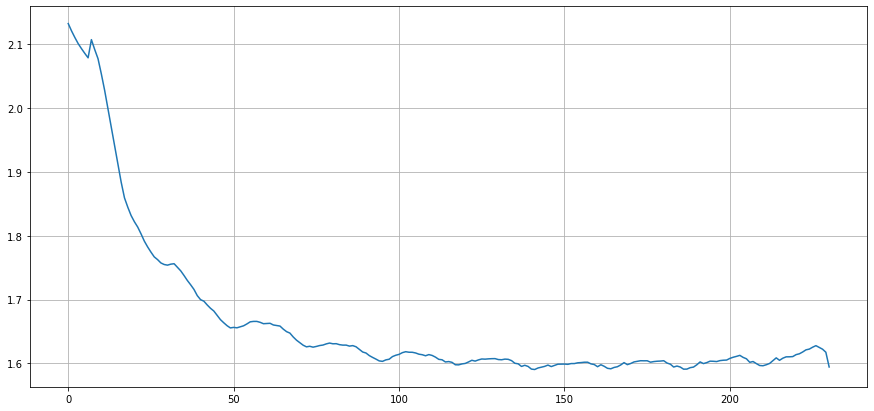

In [13]:
# eval loss

import pandas as pd

pd.Series(seq_wiki.evaluations_history["eval"]["loss"]).plot(figsize=(15, 7), grid=True)

### Unsupervised adaptation

In this experiment we'll see hiw far can we get without a large set of aligned supervised texts.

In [14]:
from adaptor.lang_module import LangModule

lang_module = LangModule("Helsinki-NLP/opus-mt-%s-%s" % (src_lang, tgt_lang))

loading configuration file https://huggingface.co/Helsinki-NLP/opus-mt-cs-en/resolve/main/config.json from cache at /home/xstefan3/.cache/huggingface/transformers/8574c5a6a6364b41827117f086812030143d2b25b92206d8b3f6d684745e8066.7bb9e3260d1abcad4452c2a159fd1668543f0b66b704f6ef4197dc58ccd92176
Model config MarianConfig {
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      62508
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 62508,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "forced_eos_token_id"

We'll use `BackTranslation` objective, that first translates the target texts into the source language using given `BackTranslator` instance. This way, we do not need to provide the objective an aligned set of samples, but we still need unsupervised data of the target language.

Of course, the eventual quality of such-trained model also heavily depends on a quaility of the BackTranslator. 

In [15]:
from adaptor.objectives.backtranslation import BackTranslation, BackTranslator

backtrans_wiki = BackTranslation(lang_module,
                                 back_translator=BackTranslator("Helsinki-NLP/opus-mt-%s-%s" % (tgt_lang, src_lang)),
                                 texts_or_path=wiki_pairs.target,
                                 val_texts_or_path=wiki_val_pairs.target,
                                 batch_size=8,
                                 share_other_objective_head=seq_wiki,
                                 objective_id="Wiki-Back")

loading configuration file https://huggingface.co/Helsinki-NLP/opus-mt-en-cs/resolve/main/config.json from cache at /home/xstefan3/.cache/huggingface/transformers/827ff170f0b812bc7aeb5b56274c2626143bc2254efa5d4df89cec71c2fec9ac.7bb9e3260d1abcad4452c2a159fd1668543f0b66b704f6ef4197dc58ccd92176
Model config MarianConfig {
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      62508
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 62508,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "forced_eos_token_id"

All the other pieces of puzzle remain the same. We'll initialise extra evaluation objective though, to be able to compare the logs of the two evaluation objectives based on their history.

In [16]:
eval_opensub_unsup = Sequence2Sequence(lang_module,
                                 texts_or_path=opensub_pairs.source,
                                 labels_or_path=opensub_pairs.target,
                                 val_texts_or_path=opensub_val_pairs.source,
                                 val_labels_or_path=opensub_val_pairs.target,
                                 source_lang_id=src_lang,
                                 target_lang_id=tgt_lang,
                                 batch_size=8,
                                 val_evaluators=evaluators,
                                 share_other_objective_head=seq_wiki,
                                 objective_id="Opensub")

2022-05-18 21:05:50 | WARNING | root | Objective Opensub-Sequence2Sequence will use SEQ2SEQ head of Wiki-Sequence2Sequence objective
2022-05-18 21:05:50 | WARNING | root | These layers of the loaded SEQ2SEQ were not merged: []


In [17]:
from adaptor.schedules import SequentialSchedule
from adaptor.adapter import Adapter

schedule = SequentialSchedule(objectives=[backtrans_wiki],
                              extra_eval_objectives=[eval_opensub_unsup],
                              args=training_arguments)
adapter = Adapter(lang_module, schedule, args=training_arguments)

2022-05-18 21:05:50 | WARNING | root | Total number of train samples: 73835
2022-05-18 21:05:50 | WARNING | root | Total number of eval samples: 200


Though this training will take somewhat longer, since the back-translation of the samples in the first epoch is performed on-the-fly.

In [ ]:
adapter.train()

## Analysis

Let's see how the supervised adaptation is doing in comparison with the unsupervised BackTranslation objective.

Thanks to Adaptor's separation to objectives, we can conveniently take a look at the validation accuracies of the two experiments, separately on in-distribution and out-of-distribution BLEU. 

In [ ]:
import pandas as pd

wiki_bleus_sup = pd.Series(seq_wiki.evaluations_history['eval'][evaluators[0]])
wiki_bleus_unsup = pd.Series(backtrans_wiki.evaluations_history['eval'][evaluators[0]])

index = range(0, len(wiki_bleus_sup)*training_arguments.eval_steps, training_arguments.eval_steps)

wiki_bleus_sup.index = index
wiki_bleus_unsup.index = index

wiki_bleus_sup.plot(figsize=(14, 5), grid=True, ylim=(0.75, 0.9), color="blue", label="In-domain validation BLEU of supervised adaptation")
wiki_bleus_unsup.plot(figsize=(14, 5), grid=True, ylim=(0.75, 0.9), color="blue", alpha=0.7, label="in-domain validation BLEU of unsupervised adaptation")

In [ ]:
opensub_bleus_sup = pd.Series(eval_opensub.evaluations_history['eval'][evaluators[0]])
opensub_bleus_unsup = pd.Series(eval_opensub_unsup.evaluations_history['eval'][evaluators[0]])

index = range(0, len(opensub_bleus_sup)*training_arguments.eval_steps, training_arguments.eval_steps)

opensub_bleus_sup.index = index
opensub_bleus_unsup.index = index

opensub_bleus_sup.plot(figsize=(14, 5), grid=True, ylim=(0.75, 0.9), color="blue", label="Out-of-domain validation BLEU of supervised adaptation")
opensub_bleus_unsup.plot(figsize=(14, 5), grid=True, ylim=(0.75, 0.9), color="blue", alpha=0.7, label="Out-of-domain validation BLEU of unsupervised adaptation")

## Evaluation

Finally, we evaluate the out models of both trainings, to see which performs better on a held-out set.

Note, that in both cases, we've used `stopping_strategy=StoppingStrategy.ALL_OBJECTIVES_CONVERGED`, so the evaluated model is the model after passing this stopping criteria.

In [ ]:
supervised_model = seq_wiki.compatible_head_model
unsupervised_model = backtrans_wiki.compatible_head_model

evaluator = BLEU(additional_sep_char="▁")

In [ ]:
def evaluate_bleu(dataset, model) -> float:
    references = []
    hypotheses = []

    for src_text, ref_text in zip(wiki_test_pairs.source, wiki_test_pairs.target):
        references.append(ref_text)
        inputs = lang_module.tokenizer(src_text, truncation=True, return_tensors="pt").to(test_device)
        outputs = translator_model.generate(**inputs)
        translations = lang_module.tokenizer.batch_decode(outputs, remove_special_tokens=True)
        hypotheses.append(translations[0])

    bleu = evaluator.evaluate_str(references, hypotheses)
    return bleu

### In-distribution BLEUs: supervised & unsupervised

In [ ]:
bleu_id_sup = evaluate_bleu(opensub_test_pairs, supervised_model)
print("Test BLEU of supervised model on Wiki: %s" % bleu_id_sup)

In [ ]:
bleu_id_unsup = evaluate_bleu(wiki_test_pairs, unsupervised_model)
print("Test BLEU of supervised model on Wiki: %s" % bleu_id_unsup)

### Out-of-distribution BLEUs: supervised & unsupervised

In [ ]:
bleu_ood_sup = evaluate_bleu(opensub_test_pairs, supervised_model)
print("Test BLEU of supervised model on Wiki: %s" % bleu_ood_sup)

In [ ]:
bleu_ood_unsup = evaluate_bleu(opensub_test_pairs, unsupervised_model)
print("Test BLEU of supervised model on Wiki: %s" % evaluate_bleu(opensub_test_pairs, unsupervised_model))